In [1]:
%load_ext autoreload
%autoreload 2

import bento as bt
import spatialdata as sd
from spatialdata.models import ShapesModel
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np
import geopandas as gpd
import shapely
from cellpose import models

LOADING
Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version. To profile in line mode, use
`%scrun [options] statement`. To profile in cell mode, use `%%scalene
[options]` followed by your code.


# Format CosMx data

Todo: add these functions to bento.geo or bento.ut?

In [3]:
sdata = sd.read_zarr("/mnt/d/sdata/cosmx_io/data.zarr/")

In [10]:
def label2shape(label_img: np.ndarray, attrs: dict, bg_value: int = 0):
    shapes = _label2shape(label_img, bg_value=bg_value)
    sd_shape = ShapesModel.parse(shapes)
    sd_shape.attrs = attrs
    return sd_shape


def _label2shape(label_img: np.ndarray, bg_value: int):
    contours = rio.features.shapes(label_img)
    polygons = np.array([(shapely.geometry.shape(p), v) for p, v in contours])
    shapes = gpd.GeoDataFrame(
        polygons[:, 1], geometry=gpd.GeoSeries(polygons[:, 0]).T, columns=["id"]
    )
    shapes = shapes[shapes["id"] != bg_value]
    return shapes

In [11]:
cells = label2shape(
    sdata["2_labels"].compute().data,
    attrs=sdata["2_labels"].attrs,
    bg_value=0,
)

In [12]:
nuc_model = models.Cellpose(model_type="nuclei")

In [13]:
masks, flows, styles, diams = nuc_model.eval(
    sdata["2_image"].compute()[2].data, diameter=30, channels=[0, 0]
)

In [17]:
nuclei = label2shape(masks, attrs=sdata["2_image"].attrs, bg_value=0)

In [18]:
from dask import dataframe as dd

points = sdata["2_points"].compute()
points = points.rename({"target": "feature_name"}, axis=1)
points = dd.from_pandas(points, npartitions=1)
points.attrs = sdata["2_points"].attrs
points.attrs["spatialdata_attrs"]["feature_key"] = "feature_name"

In [20]:
sdata2 = sd.SpatialData(
    images={"2_image": sdata["2_image"]},
    labels={"2_labels": sdata["2_labels"]},
    shapes={
        "cell_boundaries": cells,
        "nucleus_boundaries": nuclei,
    },
    points={"transcripts": points},
)

In [21]:
bt.io.prep(sdata2)

  0%|          | 0/3 [00:00<?, ?it/s]

SpatialData object with:
├── Images
│     └── '2_image': SpatialImage[cyx] (3, 3648, 5472)
├── Labels
│     └── '2_labels': SpatialImage[yx] (3648, 5472)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (2D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (3786, 4) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (3611, 3) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 3786 × 980
    obs: 'cell_boundaries', 'region'
    uns: 'spatialdata_attrs': AnnData (3786, 980)
with coordinate systems:
▸ '2', with elements:
        2_image (Images), 2_labels (Labels), transcripts (Points), cell_boundaries (Shapes), nucleus_boundaries (Shapes)
▸ 'global', with elements:
        2_image (Images), 2_labels (Labels), transcripts (Points), cell_boundaries (Shapes), nucleus_boundaries (Shapes)
▸ 'global_only_image', with elements:
        2_image (Images), nucleus_boundaries (Shapes)
▸ 'global_only_labels', with elements:
  

In [22]:
sdata2.write("/mnt/d/sdata/cosmx_io/data_2only.zarr/", overwrite=True)

no parent found for <ome_zarr.reader.Label object at 0x7effc7c498a0>: None


# Test method compatibility

In [1]:
%load_ext autoreload
%autoreload 2

import bento as bt
import spatialdata as sd
import matplotlib.pyplot as plt

In [2]:
sdata2 = sd.read_zarr("/mnt/d/sdata/cosmx_io/data_2only.zarr/")
bt.io.prep(sdata2)

  0%|          | 0/3 [00:00<?, ?it/s]

SpatialData object with:
├── Images
│     └── '2_image': SpatialImage[cyx] (3, 3648, 5472)
├── Labels
│     └── '2_labels': SpatialImage[yx] (3648, 5472)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (2D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (3786, 3) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (3611, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 3786 × 980
    obs: 'cell_boundaries', 'region'
    uns: 'spatialdata_attrs': AnnData (3786, 980)
with coordinate systems:
▸ '2', with elements:
        2_image (Images), 2_labels (Labels), transcripts (Points), cell_boundaries (Shapes), nucleus_boundaries (Shapes)
▸ 'global', with elements:
        2_image (Images), 2_labels (Labels), transcripts (Points), cell_boundaries (Shapes), nucleus_boundaries (Shapes)
▸ 'global_only_image', with elements:
        2_image (Images), nucleus_boundaries (Shapes)
▸ 'global_only_labels', with elements:
  

In [3]:
# %%scalene
res = 0.2
bt.tl.flux(sdata2, res=res, recompute=True, num_workers=16)

  0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/530 [00:00<?, ?it/s]

<built-in function len>


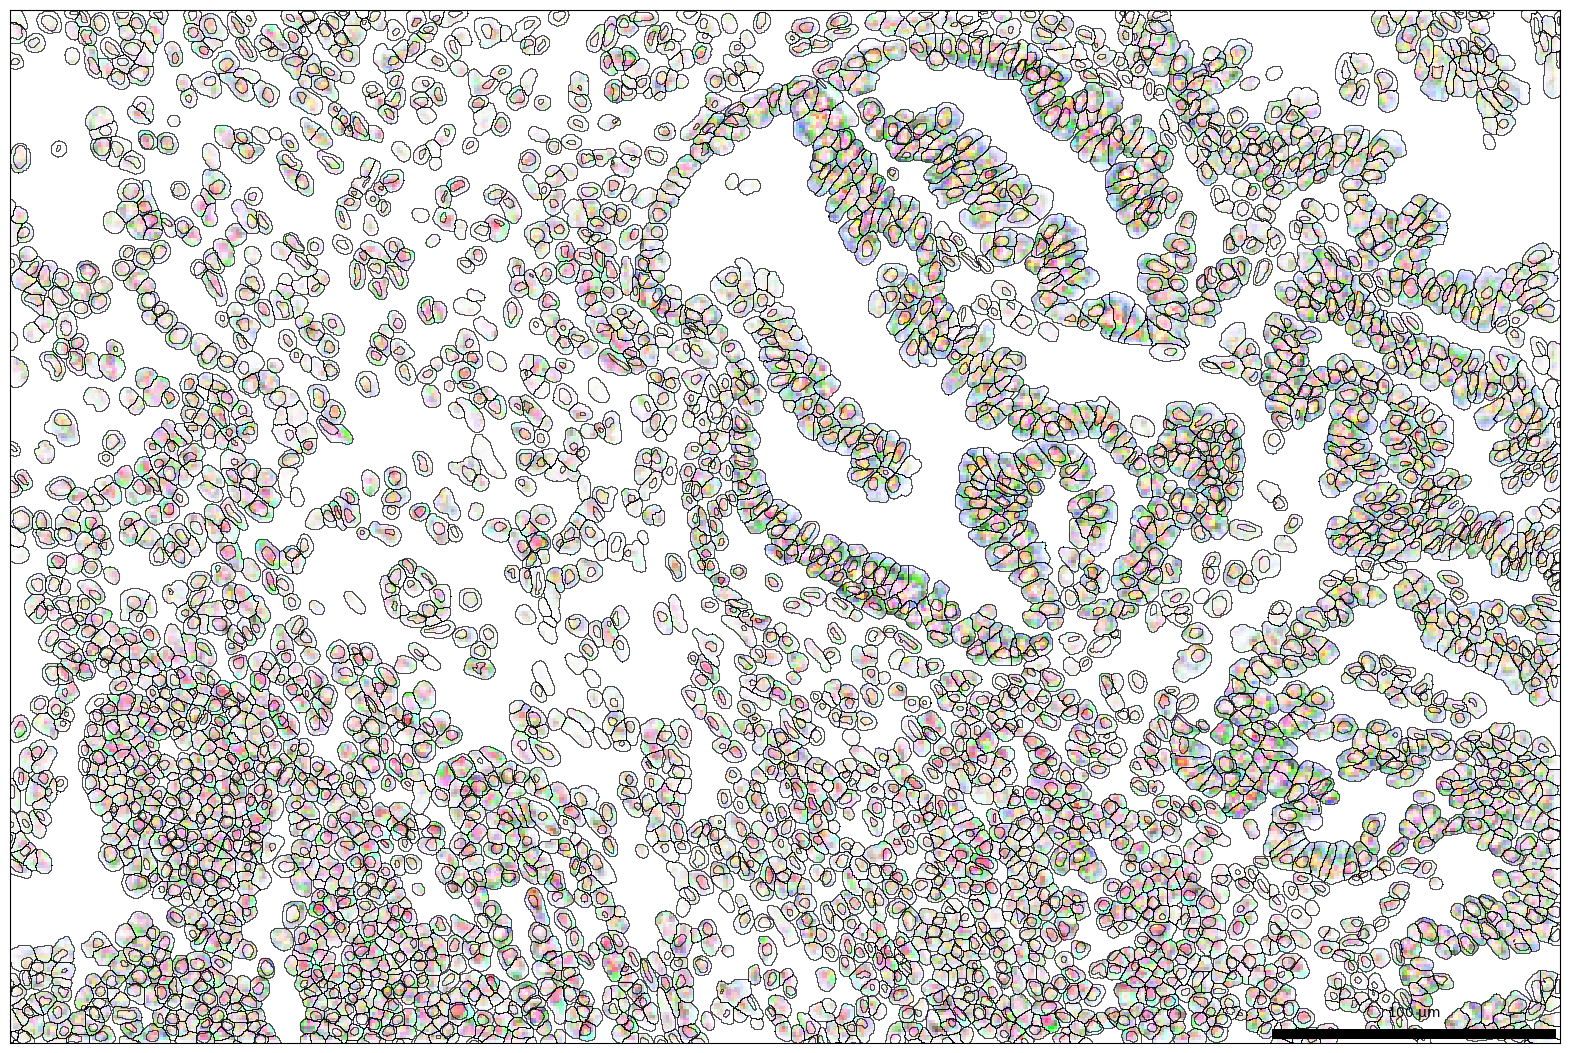

In [20]:
plt.figure(figsize=(20, 20))
bt.pl.flux(sdata2, res=0.1)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

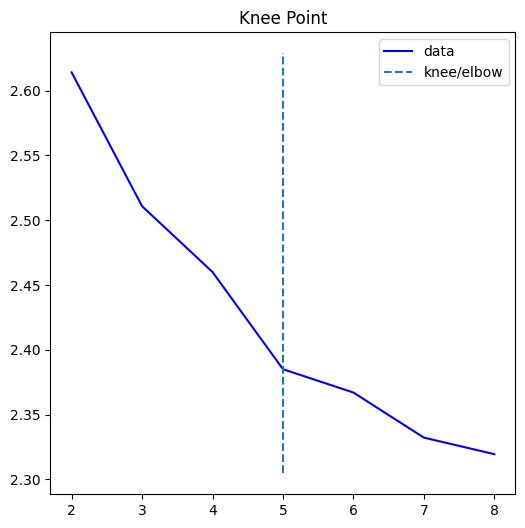

  0%|          | 0/3786 [00:00<?, ?it/s]

In [5]:
bt.tl.fluxmap(
    sdata2,
    n_clusters=range(2, 9),
    res=res,
    min_count=30,
    train_size=0.2,
    plot_error=True,
)

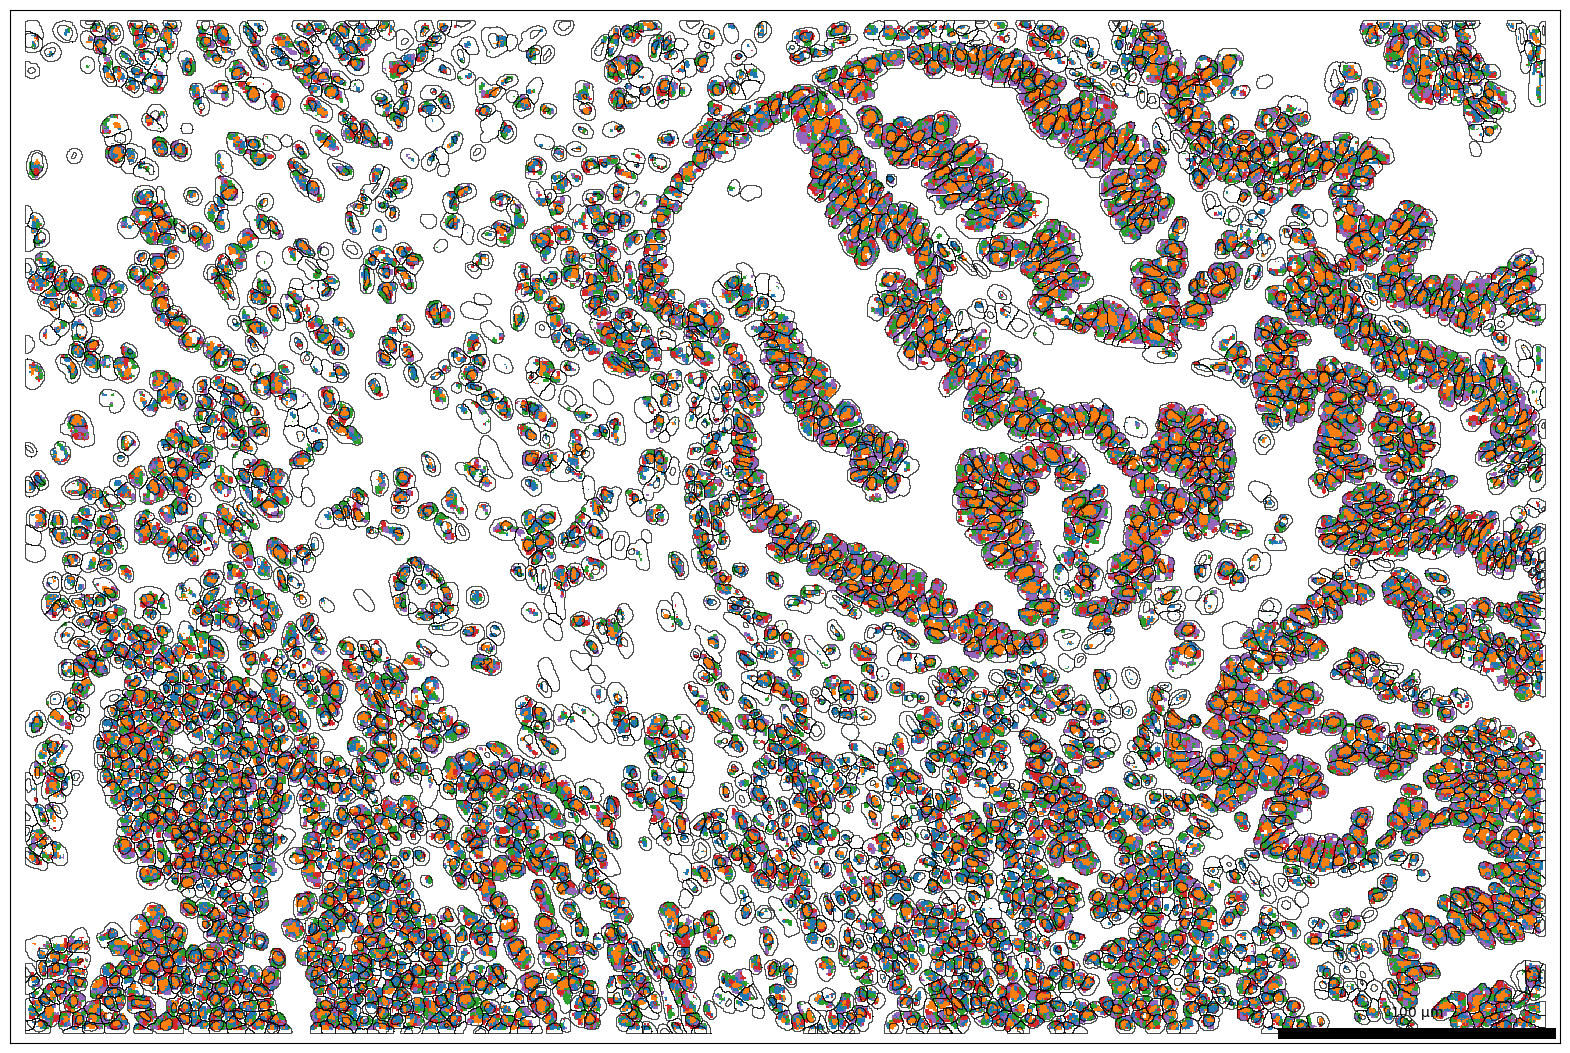

In [6]:
plt.figure(figsize=(20, 20))
bt.pl.fluxmap(sdata2)

In [7]:
fluxmap_names = [s for s in sdata2.shapes.keys() if s.startswith("fluxmap")]
bt.tl.comp(
    sdata2,
    points_key="transcripts",
    shape_names=fluxmap_names,
)

Adjusting text positions...


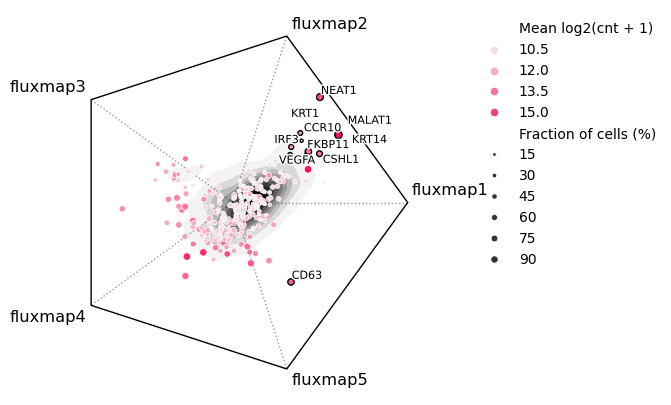

In [16]:
bt.pl.comp(sdata2, annotate=10, min_count=10)